# MX Calibrate

Calibrate a translation table from a set of powder diffraction images taken at various sample-detector distances.

This is a notebook replacement of the `MX-calibrate` tool from pyFAI with advanced features.

## Start with some constant definition:

In [1]:
calibrant_name = "CeO2"
detector_name = "Pilatus 2M"
file_pattern = "massif1/test-powder*.cbf"
result_file = "MX-calibrate.json"
wavelength = None # set a value to override the one in the headers

In [2]:
!wget http://www.silx.org/pub/pyFAI/massif1.tar.bz2
!tar -xvjf massif1.tar.bz2

--2024-12-26 10:16:04--  http://www.silx.org/pub/pyFAI/massif1.tar.bz2
Resolving www.silx.org (www.silx.org)... 195.154.237.27
Connecting to www.silx.org (www.silx.org)|195.154.237.27|:80... connected.
200 OKequest sent, awaiting response... 
Length: 6784503 (6.5M) [application/x-bzip2]
Saving to: ‘massif1.tar.bz2.3’

massif1.tar.bz2.3   100%[===================>]   6.47M  23.8MB/s    in 0.3s    

2024-12-26 10:16:05 (23.8 MB/s) - ‘massif1.tar.bz2.3’ saved [6784503/6784503]

massif1/
massif1/test-powder_5_0001.poni
massif1/test-powder_4_0001.cbf
massif1/test-powder_6_0001.poni
massif1/test-powder_8_0001.cbf
massif1/test-powder_7_0001.cbf
massif1/test-powder_7_0001.poni
massif1/test-powder_3_0001.cbf
massif1/test-powder_1_0001.poni
massif1/test-powder_4_0001.poni
massif1/test-powder_8_0001.poni
massif1/test-powder_2_0001.poni
massif1/test-powder_6_0001.cbf
massif1/test-powder_2_0001.cbf
massif1/test-powder_5_0001.cbf
massif1/test-powder_3_0001.poni
massif1/test-powder_1_0001.cbf


In [3]:
%matplotlib widget 
#inline2

In [4]:
import os
import glob
import logging
import numpy
from matplotlib.pyplot import subplots
from scipy.stats import linregress
import fabio
import pyFAI
from pyFAI.gui import jupyter
import pyFAI.calibrant
from pyFAI.gui.jupyter.calib import Calibration
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement
from pyFAI.gui.cli_calibration import AbstractCalibration
import pyFAI.gui.mpl_calib
pyFAI.gui.mpl_calib.logger.setLevel(logging.ERROR)
print(f"Running pyFAI version {pyFAI.version}")

Running pyFAI version 2025.1.0-dev0


In [5]:
detector = pyFAI.detector_factory(detector_name)
calibrant = pyFAI.calibrant.get_calibrant(calibrant_name)
files = sorted(glob.glob(file_pattern))
print("input files: "+" ".join(files))

input files: massif1/test-powder_1_0001.cbf massif1/test-powder_2_0001.cbf massif1/test-powder_3_0001.cbf massif1/test-powder_4_0001.cbf massif1/test-powder_5_0001.cbf massif1/test-powder_6_0001.cbf massif1/test-powder_7_0001.cbf massif1/test-powder_8_0001.cbf


In [6]:
first = fabio.open(files[0])

def get_dectris_headers(fimg):
    """return the dectris headers from a Pilatus detector"""
    res = {}
    for line in fimg.header.get("_array_data.header_contents", "").split("\n"):
        words = line.split()
        if len(words)>=3:
            key = words[1]
            for v in words[2:]:
                try:
                    vf = float(v)
                except:
                    continue
                if not("." in v or "e" in v):
                    vf = int(v)
                res[key] = vf
    return res

get_dectris_headers(first)

{'Silicon': 0.00045,
 'Pixel_size': 0.000172,
 'N_oscillations': 1,
 'Chi': 0.0,
 'Phi': 0.0,
 'Kappa': 0.0,
 'Alpha': 0.0,
 'Polarization': 0.99,
 'Detector_2theta': 0.0,
 'Angle_increment': 1.0,
 'Transmission': 100.0,
 'Flux': 436215830143.2828,
 'Detector_Voffset': 0.0,
 'Detector_distance': 0.126474,
 'Wavelength': 0.965459,
 'N_excluded_pixels:': 321,
 'Threshold_setting': 6421,
 'Count_cutoff': 1048500,
 'Tau': 0,
 'Exposure_period': 0.02115,
 'Exposure_time': 0.02,
 'Start_angle': 0.0}

In [7]:
if wavelength is None:
    wavelength = get_dectris_headers(first)["Wavelength"] * 1e-10
calibrant.wavelength = wavelength

In [8]:
#apply mask to the detector
mask = numpy.logical_or(detector.mask, first.data<0)
detector.mask = mask

## Manual calibration of the first image

In [9]:
# Important: select the ring number before right-click on the ring. Finally click on the refine button
calib = Calibration(img=first.data, 
                    mask=mask, 
                    detector=detector,
                    wavelength=wavelength, 
                    calibrant=calibrant)

In [10]:
calib.extract_cpt()
# calib.geoRef.rot1 = calib.geoRef.rot2 = calib.geoRef.rot3 = 0
calib.refine(fixed=["wavelength", "rot3"])

Before refinement, the geometry is:
Detector Pilatus 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 9.654590e-11 m
SampleDetDist= 1.260638e-01 m	PONI= 1.477421e-01, 1.231789e-01 m	rot1=0.020275  rot2=-0.007921  rot3=0.000000 rad
DirectBeamDist= 126.094 mm	Center: x=701.294, y=853.159 pix	Tilt= 1.247° tiltPlanRotation= -158.659° 𝛌= 0.965Å
Detector Pilatus 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 9.654590e-11 m
SampleDetDist= 1.262773e-01 m	PONI= 1.470595e-01, 1.217638e-01 m	rot1=0.009934  rot2=-0.003139  rot3=0.000000 rad
DirectBeamDist= 126.284 mm	Center: x=700.635, y=852.692 pix	Tilt= 0.597° tiltPlanRotation= -162.461° 𝛌= 0.965Å
Detector Pilatus 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 9.654590e-11 m
SampleDetDist= 1.262773e-01 m	PONI= 1.470595e-01, 1.217638e-01 m	rot1=0.009934  rot2=-0.003139  rot3=0.000000 rad
DirectBeamDist= 126.284 mm	Center: x=700.635, y=852.692 pix	Tilt= 0.597° tiltPlanRotation= -162.461° 𝛌= 0.965Å
Detector Pilatus 2M	 P

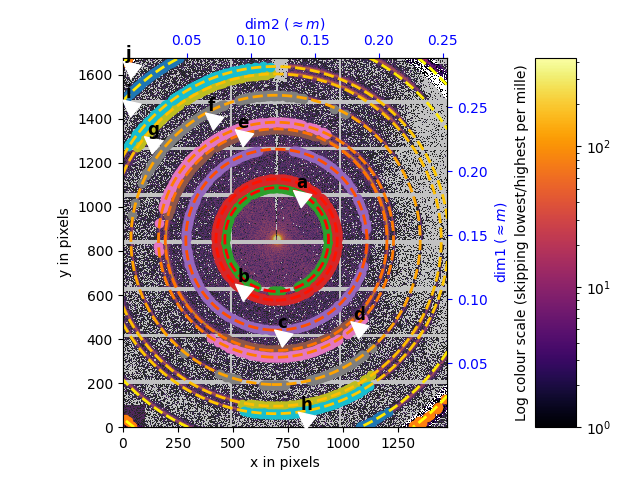

In [11]:
#Return to `inline` mode
%matplotlib inline
calib.peakPicker.widget.fig.show()

Check that the beam-center and the distance is correct and how much they are off.

## Calibration of all frames in automatic mode: 

In [12]:
# Definition of the geometry translation function:
get_distance = lambda fimg: get_dectris_headers(fimg)["Detector_distance"]

geotrans = GeometryTransformation(param_names = ["dist_offset",
                                                 "poni1", "poni2", "rot1","rot2",
                                                "dist_scale", "poni1_scale", "poni2_scale"],
                                  dist_expr="pos * dist_scale + dist_offset",
                                  poni1_expr="pos * poni1_scale + poni1",
                                  poni2_expr="pos * poni2_scale + poni2",
                                  rot1_expr="rot1",
                                  rot2_expr="rot2",
                                  rot3_expr="0.0")

param = {
         "dist_offset": calib.geoRef.dist-get_distance(first),
         "poni1": calib.geoRef.poni1,
         "poni2": calib.geoRef.poni2,
         "rot1": calib.geoRef.rot1,
         "rot2": calib.geoRef.rot2,
         "dist_scale": 1.0,
         "poni1_scale": 0.0,
         "poni2_scale": 0.0,
}

print(param)

{'dist_offset': np.float64(-0.00019671630020842712), 'poni1': np.float64(0.14705954040799238), 'poni2': np.float64(0.12176377661448436), 'rot1': np.float64(0.009933952603004578), 'rot2': np.float64(-0.0031394933763319826), 'dist_scale': 1.0, 'poni1_scale': 0.0, 'poni2_scale': 0.0}


In [13]:
# Definition of the geometry refinement: the parameter order is the same as the param_names



gonioref = GoniometerRefinement(param, #initial guess
                                pos_function=get_distance,
                                trans_function=geotrans,
                                detector=detector,
                                wavelength=wavelength)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [14]:
# Let's populate the goniometer refinement object with all geometries:
for fn in files:
    base = os.path.splitext(fn)[0]
    fimg = fabio.open(fn)
    local_calib = AbstractCalibration(img=fimg.data, mask=mask,
                                      detector=detector,
                                      wavelength=wavelength,
                                      calibrant=calibrant)
    local_calib.preprocess()
    local_calib.fixed = ["wavelength", "rot3"]
    local_calib.ai = gonioref.get_ai(get_distance(fimg))
    local_calib.extract_cpt()
    sg = gonioref.new_geometry(os.path.basename(base), image=fimg.data, metadata=fimg, 
                              control_points=local_calib.peakPicker.points,
                              geometry=local_calib.ai, 
                              calibrant=calibrant)
    
print("Filled refinement object:")
print(gonioref)
print(os.linesep+"\tLabel \t Distance")
for k, v in gonioref.single_geometries.items():
    print(k,v.get_position())

ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image av

Filled refinement object:
GoniometerRefinement with 8 geometries labeled: test-powder_1_0001, test-powder_2_0001, test-powder_3_0001, test-powder_4_0001, test-powder_5_0001, test-powder_6_0001, test-powder_7_0001, test-powder_8_0001.

	Label 	 Distance
test-powder_1_0001 0.126474
test-powder_2_0001 0.141749
test-powder_3_0001 0.199249
test-powder_4_0001 0.171074
test-powder_5_0001 0.226674
test-powder_6_0001 0.293162
test-powder_7_0001 0.357899
test-powder_8_0001 0.484611


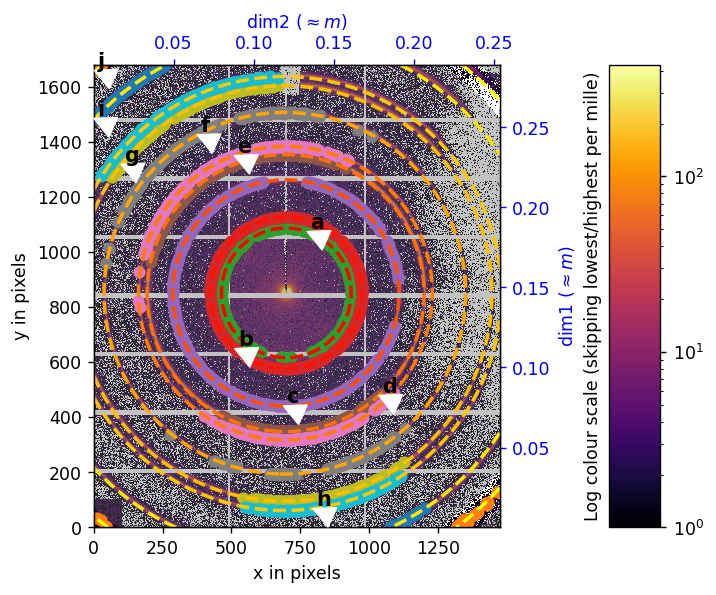

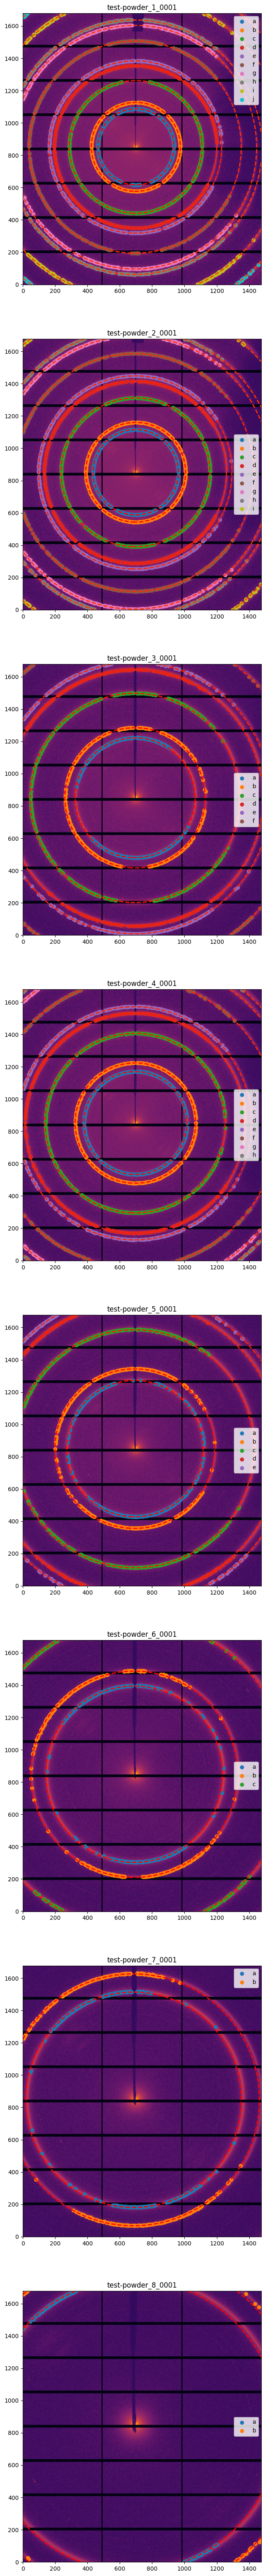

In [15]:
fig, ax = subplots(len(files), figsize=(10, 10*len(files)))
for sp, sg in zip(ax, gonioref.single_geometries.values()):
    jupyter.display(sg=sg, ax=sp, label=sg.label)

In [16]:
gonioref.refine3(fix=["dist_scale", "poni1_scale", "poni2_scale"])

Free parameters: ['dist_offset', 'poni1', 'poni2', 'rot1', 'rot2']
Fixed: {'dist_scale': 1.0, 'poni1_scale': 0.0, 'poni2_scale': 0.0}
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.2003046695358745e-07
       x: [-1.092e-04  1.469e-01  1.212e-01  5.984e-03 -1.873e-03]
     nit: 13
     jac: [-9.443e-07 -3.838e-08  5.785e-08 -2.385e-09  5.480e-08]
    nfev: 82
    njev: 13
Constrained Least square 1.3396276144821427e-06 --> 4.2003046695358745e-07
maxdelta on rot1: 0.009933952603004578 --> 0.005983688861649271 


np.float64(4.2003046695358745e-07)

In [17]:
gonioref.refine3(fix=[])

Free parameters: ['dist_offset', 'poni1', 'poni2', 'rot1', 'rot2', 'dist_scale', 'poni1_scale', 'poni2_scale']
Fixed: {}
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.5407882690422835e-07
       x: [-3.301e-04  1.468e-01  1.210e-01  7.544e-03 -2.110e-03
            1.001e+00  6.967e-04  3.335e-03]
     nit: 22
     jac: [ 1.335e-08 -9.821e-09  5.598e-08 -3.212e-08 -6.357e-08
           -5.914e-09  9.099e-08  2.704e-09]
    nfev: 201
    njev: 22
Constrained Least square 4.2003046695358745e-07 --> 3.5407882690422835e-07
maxdelta on poni2_scale: 0.0 --> 0.003334856966753146 


np.float64(3.5407882690422835e-07)

Interpretation of this fit:

In [18]:
gonioref.get_ai(0.2)

Detector Pilatus 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 9.654590e-11 m
SampleDetDist= 1.999487e-01 m	PONI= 1.469659e-01, 1.217121e-01 m	rot1=0.007544  rot2=-0.002110  rot3=0.000000 rad
DirectBeamDist= 199.955 mm	Center: x=698.859, y=852.000 pix	Tilt= 0.449° tiltPlanRotation= -164.371° 𝛌= 0.965Å

In [19]:
gonioref.get_ai(0.3)

Detector Pilatus 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 9.654590e-11 m
SampleDetDist= 3.000882e-01 m	PONI= 1.470356e-01, 1.220456e-01 m	rot1=0.007544  rot2=-0.002110  rot3=0.000000 rad
DirectBeamDist= 300.097 mm	Center: x=696.405, y=851.176 pix	Tilt= 0.449° tiltPlanRotation= -164.371° 𝛌= 0.965Å

Persistence of this fit

In [20]:
gonioref.save(result_file)

In [21]:
with open(result_file) as r:
    print(r.read())

{
  "content": "Goniometer calibration v2",
  "detector": "Pilatus 2M",
  "detector_config": {
    "orientation": 3
  },
  "wavelength": 9.65459e-11,
  "param": [
    -0.0003300822135578844,
    0.14682656697108593,
    0.12104511494589165,
    0.00754391154034123,
    -0.0021103624021599115,
    1.0013941264728727,
    0.0006966621367131724,
    0.003334856966753146
  ],
  "param_names": [
    "dist_offset",
    "poni1",
    "poni2",
    "rot1",
    "rot2",
    "dist_scale",
    "poni1_scale",
    "poni2_scale"
  ],
  "pos_names": [
    "pos"
  ],
  "trans_function": {
    "content": "GeometryTransformation",
    "param_names": [
      "dist_offset",
      "poni1",
      "poni2",
      "rot1",
      "rot2",
      "dist_scale",
      "poni1_scale",
      "poni2_scale"
    ],
    "pos_names": [
      "pos"
    ],
    "dist_expr": "pos * dist_scale + dist_offset",
    "poni1_expr": "pos * poni1_scale + poni1",
    "poni2_expr": "pos * poni2_scale + poni2",
    "rot1_expr": "rot1",
    "r

Interpretation of the fit:

In [22]:
distances = []
f_distances = []
f_poni1 = []
f_poni2 = []
g_distances = []
g_poni1 = []
g_poni2 = []
for sg in gonioref.single_geometries.values():
    distance = sg.get_position()
    distances.append(distance)
    sg.geometry_refinement.refine3(fix=["wavelength", "rot3"])
    f_distances.append(sg.geometry_refinement.dist)
    f_poni1.append(sg.geometry_refinement.poni1)
    f_poni2.append(sg.geometry_refinement.poni2)
    ai = gonioref.get_ai(distance)
    g_distances.append(ai.dist)
    g_poni1.append(ai.poni1)
    g_poni2.append(ai.poni2)

order = numpy.argsort(distances)
distances = numpy.take(distances, order)
f_distances = numpy.take(f_distances, order)
f_poni1 = numpy.take(f_poni1, order)
f_poni2 = numpy.take(f_poni2, order)
g_distances = numpy.take(g_distances, order)
g_poni1 = numpy.take(g_poni1, order)
g_poni1 = numpy.take(g_poni1, order)


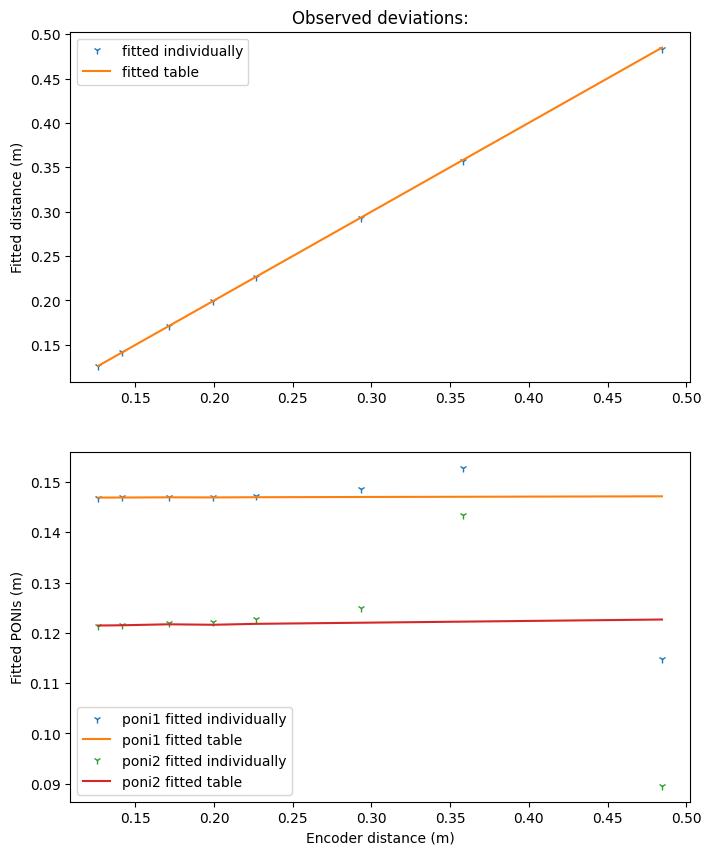

In [28]:
fig,ax = subplots(2, figsize=(8,10))
ax[0].plot(distances, f_distances, "1", label="fitted individually")
ax[0].plot(distances, g_distances, label="fitted table")
ax[0].set_title("Observed deviations:")
ax[1].set_xlabel("Encoder distance (m)")
ax[1].plot(distances, f_poni1, "1", label="poni1 fitted individually")
ax[1].plot(distances, g_poni1, label="poni1 fitted table")
ax[1].plot(distances, f_poni2, "1", label="poni2 fitted individually")
ax[1].plot(distances, g_poni2, label="poni2 fitted table")
ax[0].set_ylabel("Fitted distance (m)")
ax[1].set_ylabel("Fitted PONIs (m)")
ax[0].legend()
ax[1].legend()
pass

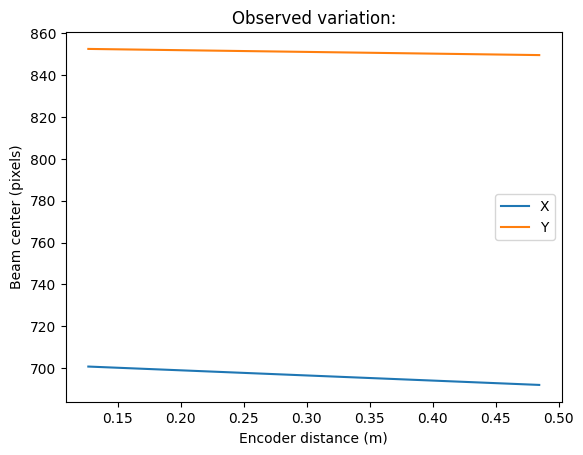

In [24]:
obtained_x = []
obtained_y = []

for dst in distances:
    geo = gonioref.get_ai(dst)
    fit2d = geo.getFit2D()
    obtained_x.append(fit2d["centerX"])
    obtained_y.append(fit2d["centerY"])
fig,ax = subplots()
ax.plot(distances, obtained_x, label="X")
ax.plot(distances, obtained_y, label="Y")
ax.set_title("Observed variation:")
ax.set_ylabel("Beam center (pixels)")
ax.set_xlabel("Encoder distance (m)")
ax.legend()
pass

In [25]:
#Simply print out the result:
lrx = linregress(distances, obtained_x)
lry = linregress(distances, obtained_y)
print(f"Beam-center X: {lrx}")
print(f"Beam-center y: {lry}")
print()
print(f"beamcenter_x = {lrx.intercept:.3f} {lrx.slope:+.3f} * encoder_value")
print(f"beamcenter_y = {lry.intercept:.3f} {lry.slope:+.3f} * encoder_value")

Beam-center X: LinregressResult(slope=np.float64(-24.5332270503757), intercept=np.float64(703.7651459543647), rvalue=np.float64(-0.9999999999999998), pvalue=np.float64(2.7372808583373344e-47), stderr=np.float64(2.1106399955786203e-07), intercept_stderr=np.float64(5.8057924229212706e-08))
Beam-center y: LinregressResult(slope=np.float64(-8.236660762016982), intercept=np.float64(853.6468813083455), rvalue=np.float64(-1.0), pvalue=np.float64(2.5000000000000343e-60), stderr=np.float64(0.0), intercept_stderr=np.float64(0.0))

beamcenter_x = 703.765 -24.533 * encoder_value
beamcenter_y = 853.647 -8.237 * encoder_value


Nota:

The degradation between 0.3 and 0.5m correspond to the image 6->7 and is related to the disparition of the third ring!

## Conclusion:

This notebook demonstrates:
* The usage of the geometry calibration in Jupyter-lab to calibrate the first image
* The creation of a goniometer-refinement 
* The population of this goniometer-refinement with automatic control-point extraction
* The fit of the table, first with the constrains of a perfecty aligned table, then with a mis-aligned table

In our case the table is miss-aligned in the horizontal direction by 2.3mm/meter (i.e. 2.3 mradian). This should be taken into account when calculating the beam-center at different distances.